In [78]:
import numpy as np 
import pandas as pd 
import os
import zipfile
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

data_root = 'plates/'
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device


device(type='cuda', index=0)

In [6]:
# with zipfile.ZipFile('input/plates.zip', 'r') as zip_obj:    
#    zip_obj.extractall('/kaggle/working/')

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


100%|██████████| 100/100 [00:00<00:00, 1111.14it/s]


In [86]:
from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
    transforms.RandomChoice([transforms.CenterCrop(180),
                                transforms.CenterCrop(160),
                                transforms.CenterCrop(140),
                                transforms.CenterCrop(120),
                                transforms.Compose([transforms.CenterCrop(280),
                                                    transforms.Grayscale(3),
                                                    ]),
                                transforms.Compose([transforms.CenterCrop(200),
                                                    transforms.Grayscale(3),
                                                    ]),
                                ]),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(0.1, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().cpu().numpy()

            
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss_list.append(epoch_loss)
                train_acc_list.append(epoch_acc)
            else:
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc)
                if epoch_loss <= best_valid_loss:
                    best_valid_loss = epoch_loss
                    model_scripted = torch.jit.script(model)
                    model_scripted.save('model_scripted.pt') 

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [81]:
class MyResNet50(torch.nn.Module):
    def __init__(self):
        super(MyResNet50, self).__init__()
        self.net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        
        for param in self.net.parameters():
            param.requires_grad = False                
        
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 2),
            # torch.nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

Epoch 0/29:


100%|██████████| 20/20 [00:04<00:00,  4.53it/s]

train Loss: 0.6383 Acc: 0.6438



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


val Loss: 0.5850 Acc: 0.7500
Epoch 1/29:


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

train Loss: 0.3980 Acc: 0.8438



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


val Loss: 0.4062 Acc: 0.8500
Epoch 2/29:


100%|██████████| 20/20 [00:04<00:00,  4.68it/s]

train Loss: 0.2827 Acc: 0.8938



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

val Loss: 0.4163 Acc: 0.8000
Epoch 3/29:



100%|██████████| 20/20 [00:04<00:00,  4.75it/s]

train Loss: 0.1472 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


val Loss: 0.2775 Acc: 0.8500
Epoch 4/29:


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

train Loss: 0.1164 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

val Loss: 0.3002 Acc: 0.8750
Epoch 5/29:



100%|██████████| 20/20 [00:04<00:00,  4.78it/s]

train Loss: 0.1294 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


val Loss: 0.3749 Acc: 0.8250
Epoch 6/29:


100%|██████████| 20/20 [00:04<00:00,  4.73it/s]

train Loss: 0.2061 Acc: 0.9125



100%|██████████| 5/5 [00:00<00:00,  5.81it/s]

val Loss: 0.3292 Acc: 0.8500
Epoch 7/29:



100%|██████████| 20/20 [00:04<00:00,  4.76it/s]

train Loss: 0.1501 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

val Loss: 0.3651 Acc: 0.8500


Epoch 8/29:


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

train Loss: 0.1334 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00,  5.79it/s]

val Loss: 0.3425 Acc: 0.9000
Epoch 9/29:



100%|██████████| 20/20 [00:04<00:00,  4.69it/s]

train Loss: 0.1209 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


val Loss: 0.2744 Acc: 0.8750
Epoch 10/29:


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]

train Loss: 0.1806 Acc: 0.9313



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


val Loss: 0.2596 Acc: 0.8500
Epoch 11/29:


100%|██████████| 20/20 [00:04<00:00,  4.69it/s]

train Loss: 0.1369 Acc: 0.9437



100%|██████████| 5/5 [00:00<00:00,  5.84it/s]

val Loss: 0.3504 Acc: 0.8250
Epoch 12/29:



100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

train Loss: 0.1861 Acc: 0.9250



100%|██████████| 5/5 [00:00<00:00, 14.79it/s]

val Loss: 0.3088 Acc: 0.8500
Epoch 13/29:



100%|██████████| 20/20 [00:02<00:00,  7.10it/s]

train Loss: 0.0701 Acc: 0.9875



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

val Loss: 0.3059 Acc: 0.8250
Epoch 14/29:



100%|██████████| 20/20 [00:04<00:00,  4.78it/s]

train Loss: 0.1578 Acc: 0.9375



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

val Loss: 0.2729 Acc: 0.9000
Epoch 15/29:



100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

train Loss: 0.0959 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00,  5.75it/s]

val Loss: 0.2697 Acc: 0.9000
Epoch 16/29:



100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

train Loss: 0.0814 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.67it/s]

val Loss: 0.3163 Acc: 0.8500
Epoch 17/29:



100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

train Loss: 0.1211 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.80it/s]

val Loss: 0.3029 Acc: 0.8500
Epoch 18/29:



100%|██████████| 20/20 [00:04<00:00,  4.56it/s]

train Loss: 0.1016 Acc: 0.9563



100%|██████████| 5/5 [00:00<00:00,  5.56it/s]

val Loss: 0.2984 Acc: 0.8500
Epoch 19/29:



100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

train Loss: 0.0975 Acc: 0.9750



100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


val Loss: 0.2324 Acc: 0.9000
Epoch 20/29:


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

train Loss: 0.0679 Acc: 0.9875



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

val Loss: 0.2980 Acc: 0.8250
Epoch 21/29:



100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

train Loss: 0.0966 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00,  5.88it/s]

val Loss: 0.2894 Acc: 0.8750
Epoch 22/29:



100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

train Loss: 0.0663 Acc: 0.9875



100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


val Loss: 0.2310 Acc: 0.8750
Epoch 23/29:


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]

train Loss: 0.0798 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

val Loss: 0.2827 Acc: 0.8500
Epoch 24/29:



100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

train Loss: 0.0938 Acc: 0.9812



100%|██████████| 5/5 [00:00<00:00,  5.90it/s]

val Loss: 0.2779 Acc: 0.9000
Epoch 25/29:



100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

train Loss: 0.0961 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.86it/s]

val Loss: 0.2489 Acc: 0.8750
Epoch 26/29:



100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

train Loss: 0.0926 Acc: 0.9625



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

val Loss: 0.3558 Acc: 0.8500
Epoch 27/29:



100%|██████████| 20/20 [00:04<00:00,  4.80it/s]

train Loss: 0.0723 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00,  5.87it/s]

val Loss: 0.3302 Acc: 0.8250
Epoch 28/29:



100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

train Loss: 0.0978 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00,  5.83it/s]

val Loss: 0.2782 Acc: 0.8750
Epoch 29/29:



100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

train Loss: 0.0857 Acc: 0.9688



100%|██████████| 5/5 [00:00<00:00,  5.85it/s]

val Loss: 0.3107 Acc: 0.8750


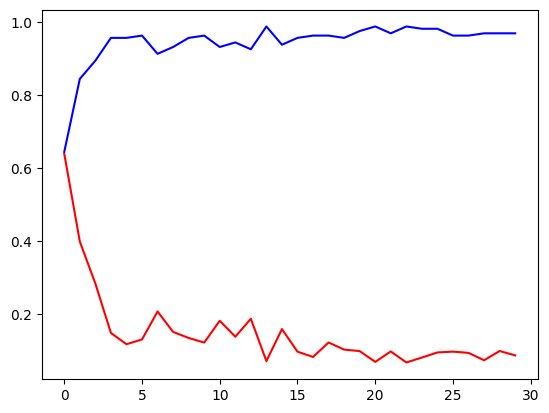

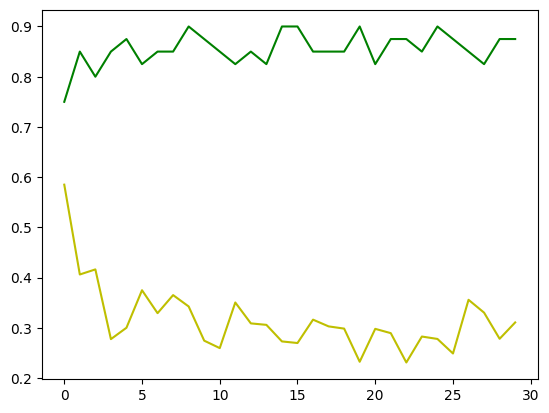

In [87]:
model = MyResNet50().to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


train_loss_list, val_loss_list, train_acc_list, val_acc_list = train_model(model, loss, optimizer, scheduler, num_epochs=30)


plt.plot(train_loss_list, c='r')
plt.plot(train_acc_list, c='b')
plt.show()
plt.plot(val_loss_list, c='y')
plt.plot(val_acc_list, c='g')
plt.show()

In [88]:
def accuracy(test_predictions, test_lables):
    top_1 = sum(map(lambda x, y: (1 if x > 0.5 else 0) == y, test_predictions, test_lables)) / len(test_predictions) * 100 
    return top_1

test_dir = data_root + 'test'
test_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=20, shuffle=False, num_workers=0)

test_predictions = []
test_lables = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions += list(torch.nn.functional.softmax(preds, dim=1)[:,1].data)
    test_lables += list(labels)
print('Accuracy: {:.2f}%' .format(accuracy(test_predictions, test_lables)))



100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Accuracy: 96.00%
